In [48]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']=150
import seaborn as sns
sns.set()
import meshio
from os.path import join
from glob import glob
import cmocean
from scipy.interpolate import griddata
from tqdm import tqdm
from scipy.io import savemat

In [10]:
def get_data(fp):
    '''read data in from single file'''
    data = meshio.read(fp)
    x,y   = data.points[:,0],                  data.points[:,1] ### x, y, (z)
    u,v   = data.point_data['velocity'][:,0], data.point_data['velocity'][:,1] ## u,v,()
    return data.points[:,:2], np.sqrt(u**2+v**2)

def regrid(points, values, x_cutoff=1.65):
    '''Regrid to regular grid, 256 x 64'''
    ### Get subset before interpolation
    idx = points[:,0]<x_cutoff
    grid_x, grid_y = np.mgrid[0:1.6:256j, 0:.41:64j]
    data_regrid = griddata(points[idx], values[idx], (grid_x, grid_y), method='cubic')
    return grid_x, grid_y, data_regrid

fp              = '/home/theo/research/elmer2/'
experiment_name = 'vs_nu1e-3_vin_test2'
filenames      = sorted(glob(join(fp,experiment_name, '*.vtu')))

grid_x, grid_y, _ = regrid(*get_data(filenames[0]))
data_regridded = []
for f in tqdm(filenames):
    _,_,d = regrid(*get_data(f))
    data_regridded.append(d)
data_regridded = np.stack(data_regridded)    

100%|███████████████████████████████████████████████████| 400/400 [00:10<00:00, 37.92it/s]


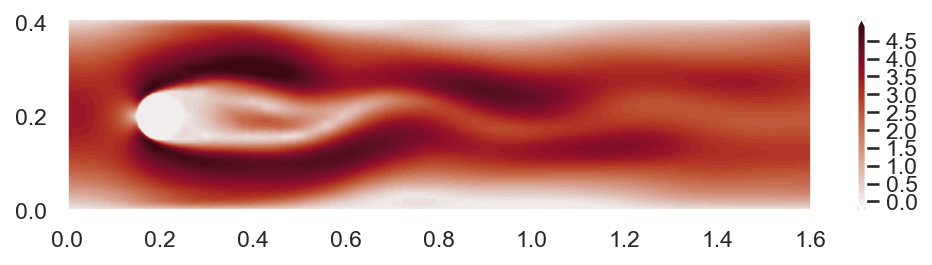

In [7]:
fig,ax=plt.subplots(figsize=(8,1.7))
p = ax.contourf(grid_x, grid_y , data_regridded[309], levels=np.arange(0,5,.1),cmap='cmo.amp', extend='both')
# ax.scatter(x,y,s=1)
ax.set_xlim([0,1.6])
cb = fig.colorbar(p)
plt.show()

#### Plot input profile

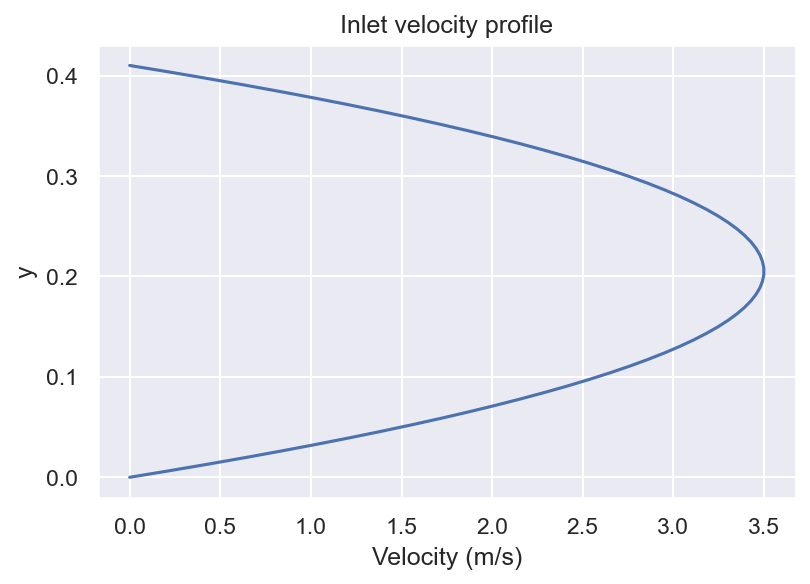

In [24]:
v_in = 4*3.5*grid_y[0,:]*(0.41-grid_y[0,:])/0.41**2
fig,ax=plt.subplots()
ax.plot(v_in, grid_y[0,:])
ax.set_xlabel('Velocity (m/s)')
ax.set_ylabel('y')
ax.set_title('Inlet velocity profile')
plt.show()

## Save to files

In [45]:
data = {'speed' : data_regridded,
        't'     : np.arange(0,.002*400,.002),
        'x'     : grid_x[:,0],
        'y'     : grid_y[0,:]}

# Plot raw mesh (before interpolation

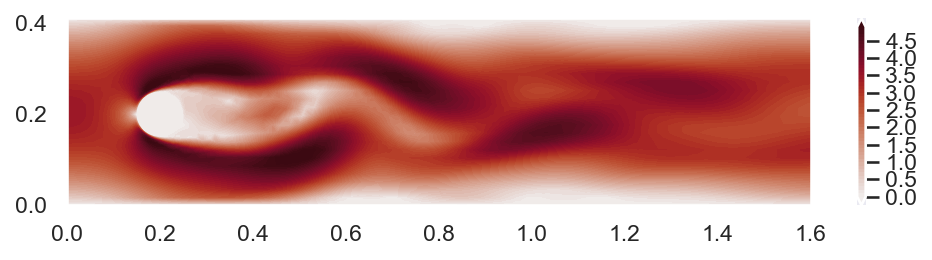

In [4]:
t1 = meshio.read(join(fp,experiment_name,filenames[370]))

x,y   = t1.points[:,0],                  t1.points[:,1] ### x, y, (z)
u,v   = t1.point_data['velocity'][:,0], t1.point_data['velocity'][:,1] ## u,v,()
speed = np.sqrt(u**2+v**2)

fig,ax=plt.subplots(figsize=(8,1.65))
ax.scatter(x,y,s=1)
p = ax.tricontourf(x,y,speed, levels=np.arange(0,5,.1),cmap='cmo.amp', extend='both')
ax.set_xlim([0,1.6])
cb = fig.colorbar(p)

### Get subset before interpolation
idx = x<1.65
grid_x, grid_y = np.mgrid[0:1.6:256j, 0:.41:64j]
grid = griddata(t1.points[idx,:2], speed[idx], (grid_x, grid_y), method='cubic')